In [1]:
from pathlib import PurePath, Path
import copy

pp = PurePath(Path.cwd()).parts[:-1]
pdir = PurePath(*pp)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(theme='onedork')

from scipy.spatial import distance
from scipy.spatial import KDTree
from sklearn.neighbors import BallTree

from multiprocessing import Pool

In [21]:
data = pd.read_csv(str(pdir) + '/data/eurusddata_big.csv', delimiter=',', header=0, parse_dates=[0])
bid, ask = pd.read_csv(str(pdir) + '/data/eurusd-bid-1h.csv'), pd.read_csv(str(pdir) + '/data/eurusd-ask-1h.csv')
mids = ((bid.iloc[:, 1] + ask.iloc[:, 1]) / 2).dropna()

In [10]:
# In this block we define methods for finding delay

def mutual_information(x, y, bins=64):
    """
    fn: calc mutual information between two random variables,
        I = S(x) + S(y) - S(x,y), between two
        random variables x and y, where S(x) is the Shannon entropy

    :param x: 1D array, first var
    :param y: 1D array, second var
    :param bins: int, number of bins for histogram
    :return: float, mutual information
    """
    p_x = np.histogram(x, bins)[0]
    p_y = np.histogram(y, bins)[0]
    p_xy = np.histogram2d(x, y, bins)[0].flatten()

    # Convert frequencies into probabilities.
    p_x = p_x[p_x > 0] / np.sum(p_x)
    p_y = p_y[p_y > 0] / np.sum(p_y)
    p_xy = p_xy[p_xy > 0] / np.sum(p_xy)

    # Calculate the corresponding Shannon entropies.
    h_x = np.sum(p_x * np.log2(p_x))
    h_y = np.sum(p_y * np.log2(p_y))
    h_xy = np.sum(p_xy * np.log2(p_xy))

    return h_xy - h_x - h_y

def time_delayed_mutual_information(x, maxtau=1000, bins=64):
    """
    fn: calc mutual information between x_i and x_{i + t} (i.e., the
        time-delayed mutual information)

    :param x: 1D array of time series
    :param maxtau: int, time delay
    :param bins: int, number of bins for histogram
    :return: array with time-delayed mutual information up to maxtau
    """
    N = len(x)
    maxtau = min(N, maxtau)

    ii = np.empty(maxtau)

    for tau in range(1, maxtau):
        ii[tau] = mutual_information(x[:-tau], x[tau:], bins)

    return ii

def locmin(x, verbose=False):
    """
    fn: all local minimas of time-series

    :param x: 1D array of time series
    :return: array with local minimas
    """
    lm = (np.diff(np.sign(np.diff(x))) > 0).nonzero()[0] + 1
    if verbose:
        print(r'Minima of delayed mutual information = %s' % lm)

    return lm

def plot_mutual_information(data):
    plt.title('Delayed mutual information of ccy pair')
    plt.xlabel(r'$\tau$')
    plt.ylabel(r'$I(\tau)$')
    plt.plot(data)
    plt.show()
    
def plot_delayed_series(data, tau):
    plt.title(r'Time delay = %d' % tau)
    plt.xlabel(r'$x(t)$')
    plt.ylabel(r'$x(t + \tau)$')
    plt.plot(data[:-tau], data[tau:])
    plt.show()

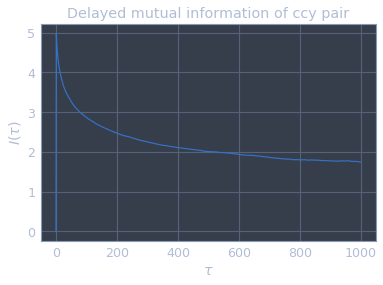

In [23]:
time_delayed_mi = time_delayed_mutual_information(mids)
plot_mutual_information(time_delayed_mi)

In [30]:
# all local minimas of time-series
locmin(time_delayed_mi, False)

array([381, 383, 399, 404, 423, 444, 449, 470, 494, 497, 502, 514, 518,
       522, 540, 544, 551, 564, 570, 574, 614, 619, 629, 640, 661, 664,
       666, 690, 708, 710, 712, 716, 734, 737, 741, 747, 758, 763, 781,
       785, 801, 803, 808, 814, 829, 848, 852, 860, 872, 880, 884, 886,
       888, 903, 906, 909, 916, 922, 943, 945, 952, 957, 976, 980, 984,
       988, 994])

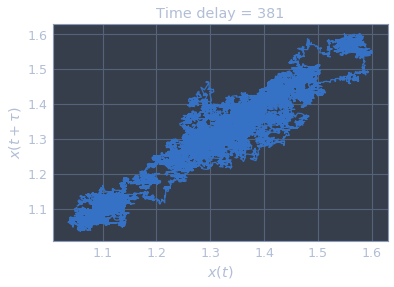

In [29]:
# taking first minima for test purposes only
delay = locmin(time_delayed_mi, False)[0]
# not the pretty picture I was expecting to get ...
plot_delayed_series(mids, tau=delay)

In [31]:
# In this block we define methods for finding dimension

def dist(x, y, metric='chebyshev'):
    """
    fn: Compute the distance between all sequential pairs of points.

        Computes the distance between all sequential pairs of points from
        two arrays using scipy.spatial.distance.

    :param x: 1D input array
    :param y: 1D input array
    :param metric: string, optional (default = 'chebyshev')
        Metric to use while computing distances.
    :return: array with distances
    """
    func = getattr(distance, metric)
    return np.asarray([func(i, j) for i, j in zip(x, y)])

def reconstruct(x, dim=1, tau=1):
    """
    fn: Construct time-delayed vectors from a time series.

    :param x: 1D time-series
    :param dim: int, optional (default = 1)
        Embedding dimension.
    :param tau: int, optional (default = 1)
        Time delay
    :return: array with time-delayed vectors
    """
    m = len(x) - (dim - 1) * tau
    if m <= 0:
        raise ValueError('Length of the time series is <= (dim - 1) * tau.')

    return np.asarray([x[i:i + (dim - 1) * tau + 1:tau] for i in range(m)])


def neighbors(y, metric='chebyshev', window=0, maxnum=None):
    """
    fn: Find nearest neighbors of all points in the given array.

        Finds the nearest neighbors of all points in the given array using
        SciPy's KDTree search.

    :param y: ndarray
        N-dimensional array containing time-delayed vectors.
    :param metric: str, optional (default = 'chebyshev')
        Metric to use for distance computation.  Must be one of
        "cityblock" (aka the Manhattan metric), "chebyshev" (aka the
        maximum norm metric), or "euclidean".
    :param window: int, optional (default = 0)
        Minimum temporal separation (Theiler window) that should exist
        between near neighbors.  This is crucial while computing
        Lyapunov exponents and the correlation dimension.
    :param maxnum: nt, optional (default = None (optimum))
        Maximum number of near neighbors that should be found for each
        point.  In rare cases, when there are no neighbors that are at a
        nonzero distance, this will have to be increased (i.e., beyond
        2 * window + 3).
    :return:
        index: array
            Array containing indices of near neighbors.
        dist: array
            Array containing near neighbor distances.
    """
    if metric == 'cityblock':
        p = 1
    elif metric == 'euclidean':
        p = 2
    elif metric == 'chebyshev':
        p = np.inf
    else:
        raise ValueError('Unknown metric.  Should be one of "cityblock", '
                         '"euclidean", or "chebyshev".')

    tree = KDTree(y)
    n = len(y)

    if not maxnum:
        maxnum = (window + 1) + 1 + (window + 1)
    else:
        maxnum = max(1, maxnum)

    if maxnum >= n:
        raise ValueError('maxnum is bigger than array length.')

    dists = np.empty(n)
    indices = np.empty(n, dtype=int)

    for i, x in enumerate(y):
        for k in range(2, maxnum + 2):
            dist, index = tree.query(x, k=k, p=p)
            valid = (np.abs(index - i) > window) & (dist > 0)

            if np.count_nonzero(valid):
                dists[i] = dist[valid][0]
                indices[i] = index[valid][0]
                break

            if k == (maxnum + 1):
                raise Exception('Could not find any near neighbor with a '
                                'nonzero distance.  Try increasing the '
                                'value of maxnum.')

    return np.squeeze(indices), np.squeeze(dists)


def parallel_map(func, values, args=tuple(), kwargs=dict(),
                 processes=None):
    """
    fn: Use Pool.apply_async() to get a parallel map().

    :param func: function
        This function will be applied on every element of values in
        parallel.
    :param values: array
        Input array
    :param args: tuple, optional (default: ())
        Additional arguments for func.
    :param kwargs: dictionary, optional (default: {})
        Additional keyword arguments for func.
    :param processes: int, optional (default: None)
        Number of processes to run in parallel.  By default, the output
        of cpu_count() is used.
    :return: array
        Output after applying func on each element in values.
    """

    # True single core processing, in order to allow the func to be executed in
    # a Pool in a calling script.
    if processes == 1:
        return np.asarray([func(value, *args, **kwargs) for value in values])

    pool = Pool(processes=processes)
    results = [pool.apply_async(func, (value,) + args, kwargs)
               for value in values]

    pool.close()
    pool.join()

    return np.asarray([result.get() for result in results])

def _fnn(d, x, tau=1, R=10.0, A=2.0, metric='euclidean', window=10,
         maxnum=None):
    """ fn: Return fraction of false nearest neighbors for a single d.

        Returns the fraction of false nearest neighbors for a single d.
        This function is meant to be called from the main fnn() function.

    """

    # We need to reduce the number of points in dimension d by tau
    # so that after reconstruction, there'll be equal number of points
    # at both dimension d as well as dimension d + 1.
    y1 = reconstruct(x[:-tau], d, tau)
    y2 = reconstruct(x, d + 1, tau)

    # Find near neighbors in dimension d.
    index, distances = neighbors(y1, metric=metric, window=window,
                                  maxnum=maxnum)

    # Find all potential false neighbors using Kennel et al.'s tests.
    f1 = np.abs(y2[:, -1] - y2[index, -1]) / distances > R
    f2 = dist(y2, y2[index], metric=metric) / np.std(x) > A
    f3 = f1 | f2

    return np.mean(f1), np.mean(f2), np.mean(f3)

def fnn(x, dim=[1], tau=1, R=10.0, A=2.0, metric='euclidean', window=10,
        maxnum=None, parallel=True):
    """fn: Compute the fraction of false nearest neighbors.

    Parameters
    ----------
    x : array
        1-D real input array containing the time series.
    dim : int array (default = [1])
        Embedding dimensions for which the fraction of false nearest
        neighbors should be computed.
    tau : int, optional (default = 1)
        Time delay.
    R : float, optional (default = 10.0)
        Tolerance parameter for FNN Test I.
    A : float, optional (default = 2.0)
        Tolerance parameter for FNN Test II.
    metric : string, optional (default = 'euclidean')
        Metric to use for distance computation.  Must be one of
        "cityblock" (aka the Manhattan metric), "chebyshev" (aka the
        maximum norm metric), or "euclidean".  Also see Notes.
    window : int, optional (default = 10)
        Minimum temporal separation (Theiler window) that should exist
        between near neighbors.
    maxnum : int, optional (default = None (optimum))
        Maximum number of near neighbors that should be found for each
        point.  In rare cases, when there are no neighbors that are at a
        nonzero distance, this will have to be increased (i.e., beyond
        2 * window + 3).
    parallel : bool, optional (default = True)
        Calculate the fraction of false nearest neighbors for each d
        in parallel.

    Returns
    -------
    f1 : array
        Fraction of neighbors classified as false by Test I.
    f2 : array
        Fraction of neighbors classified as false by Test II.
    f3 : array
        Fraction of neighbors classified as false by either Test I
        or Test II.

    """
    if parallel:
        processes = None
    else:
        processes = 1

    return parallel_map(_fnn, dim, (x,), {
                              'tau': tau,
                              'R': R,
                              'A': A,
                              'metric': metric,
                              'window': window,
                              'maxnum': maxnum
                              }, processes).T

def plot_fnn(dim, f1, f2, f3):
    plt.title(r'FNN for Ccy pair')
    plt.xlabel(r'Embedding dimension $d$')
    plt.ylabel(r'FNN (%)')
    plt.plot(dim, 100 * f1, 'bo--', label=r'Test I')
    plt.plot(dim, 100 * f2, 'g^--', label=r'Test II')
    plt.plot(dim, 100 * f3, 'rs-', label=r'Test I + II')
    plt.axhline(y=10, color='k', linestyle='dashed')
    plt.legend()

    plt.show()

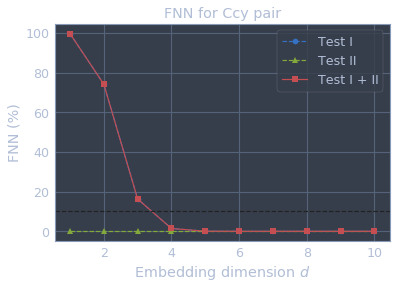

In [32]:
# Takes time to calculate
dim = np.arange(1, 10 + 1)
f1, f2, f3 = fnn(mids.values, tau=delay, dim=dim, window=10, metric='cityblock')
plot_fnn(dim, f1, f2, f3)

In [33]:
# Judging from the plot above FNN goes beyond 10% in dim=3
m = 3

def embedding(data, tau, m):
    """
    fn: Given time-delay and number of dimension returns embedded data

    :param data: 1D time-series
    :param tau: int, time-delay
    :param m: int, dimension
    :return: md array with embedded data
    """
    points = []

    for i, row in enumerate(data):
        point = []
        for j in range(m):
            if i + j * tau < len(data):
                point.append(data[i + j * tau])

        if len(point) == m:
            points.append(point)

    return points

embedded = embedding(data.Price, tau=delay, m=m)

In [34]:
# In this block we define methods for KNN

def knn_data(embedded_x):
    print('Number of embedding dimensions = {0}'.format(len(embedded_x[0])))
    embedding_featureset = []; embedding_labels = []
    for i, vector in enumerate(embedded_x):
        if(i + 1) >= len(embedded_x):
            break

        embedding_featureset.append(vector)
        embedding_labels.append(embedded_x[i + 1])

    assert len(embedding_featureset) == len(embedding_labels), "Did not get equal amount of predictions as points"

    fraction = 8.0 / 10.0
    train_set = (embedding_featureset[:int(fraction * len(embedding_featureset))],
                 embedding_labels[:int(fraction * len(embedding_featureset))])
    test_set = (embedding_featureset[int(fraction * len(embedding_featureset)):],
                embedding_labels[int(fraction * len(embedding_featureset)):])

    return train_set, test_set

def majority(item_indices, k=5):
    """
    fn: Given the indices of training examples, return the majority label.  If
    there's a tie, return the median of the majority labels (as implemented 
    in numpy).

    :param item_indices: The indices of the k nearest neighbors
    """
    assert len(item_indices) == k, "Did not get k inputs"

    # Get the labels of the k nearest neighbors
    knn_labels = []
    for item_index in item_indices:
        knn_labels.append(y_train[item_index])

    # Return the average of the next label
    average_vector = []
    for i in range(len(knn_labels[0])):
        average_vector.append(np.average([row[i] for row in knn_labels]))

    return average_vector

def knn_predict(feature_example):
    dist, ind = kdtree.query(np.array(feature_example).reshape(1, -1), k=5)
    
    return majority(ind[0])

def knn_error(prediction, truth, training):
    assert len(prediction) == len(truth), "Number of predictions much equal the number of real data points."
    error = np.abs(np.array(prediction) - np.array(truth))
    random_walk = np.abs(np.diff(training, axis = 0)).sum()
    
    # returning MASE
    return np.array(error/((len(prediction)/(len(training) - 1.0))*random_walk)).sum()

In [35]:
train_set, test_set = knn_data(embedded)

X_train, y_train = train_set[0], train_set[1]
X_test, y_test = test_set[0], test_set[1]

kdtree = BallTree(X_train)
k = 5 # default k for KNN method
print('Data loaded for KNN k = {0}'.format(k))

# prediction on train set

prediction = []; truth = []
for i in range(len(X_train)):
    xx, yy = X_train[i], y_train[i]
    prediction_embedded = knn_predict(xx)
    
    prediction.append(prediction_embedded[0])
    truth.append(yy[0])
    
# Calculate the average error on train set
training = [row[0] for row in X_train]
print("Error on training set: {0}".format(knn_error(prediction, truth, training)))

# now for test set

prediction = []; truth = [];
for i in range(len(X_test)):
    xx, yy = X_test[i], y_test[i]
    prediction_embedded = knn_predict(xx)

    prediction.append(prediction_embedded[0])
    truth.append(yy[0])
    
training = [row[0] for row in X_test]
print("Error on test set: {0}".format(knn_error(prediction, truth, training)))

Number of embedding dimensions = 3
Data loaded for KNN k = 5
Error on training set: 0.8787054893812688
Error on test set: 7.060602964626625
